# $\rho'$ analysis notes

### Data scheme

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import pandas as ps
import awkward

ccup9_2015_my_test = r"D:\GoogleDrive\Job\cern\Alice\analysis\dev\grid\selection\RhoPrime\macro\AnalysisResults.root"
ccup9_2015_my = r'D:\GoogleDrive\Job\cern\Alice\analysis\data\RhoPrime\2015\RhoPrime2015o.root'

events = uproot.open(ccup9_2015_my)['RhoPrimeCentral/events']
entries = events.numentries
events.show()
print(events.name, events.title, events.numentries)

# mycache = uproot.ArrayCache(1024*1024 * 10)
data = events.arrays('*', namedecode="utf-8")
data['nTracks'].sum() 


RunNum                     (no streamer)              asdtype('>i4')
PeriodNumber               (no streamer)              asdtype('>u4')
OrbitNumber                (no streamer)              asdtype('>u4')
BunchCrossNumber           (no streamer)              asdtype('>u2')
Mass                       (no streamer)              asdtype('>f4')
Pt                         (no streamer)              asdtype('>f4')
Q                          (no streamer)              asdtype('>i2')
Rapidity                   (no streamer)              asdtype('>f4')
Phi                        (no streamer)              asdtype('>f4')
ZNAenergy                  (no streamer)              asdtype('>f4')
ZNCenergy                  (no streamer)              asdtype('>f4')
ZPAenergy                  (no streamer)              asdtype('>f4')
ZPCenergy                  (no streamer)              asdtype('>f4')
VtxX                       (no streamer)              asdtype('>f4')
VtxY                       (no str

3757097

### Run numbers from 2015o period

In [3]:
print (np.unique(data['RunNum']))

# runs = data['RunNum'][GoodEvents]

# counts = plt.hist(runs,bins=len(np.unique(runs)))

# bins = []
# counts = []

# for run in np.unique(runs):
#     bins.append(run)
#     counts.append((data['RunNum'][GoodEvents] == run).sum())
#     print(run, (data['RunNum'][GoodEvents] == run).sum())


# plt.style. use(hep.style.ROOT)
# fig = plt.figure(figsize=(15, 7))
# ax = fig.add_axes([0,0,1,1])
# fig.suptitle('4pr events by run', fontsize=32)
# ax.bar(bins,counts,width=5 )
# # ax.set_xticks(bins)
# # ax.set_xticklabels(bins,rotation=90, rotation_mode="anchor", ha="right")
# plt.show()



[245145 245146 245151 245152 245231 245232 245259 245345 245346 245347
 245349 245353 245396 245397 245401 245407 245409 245410 245411 245441
 245446 245450 245453 245496 245501 245504 245505 245507 245540 245542
 245543 245544 245545 245554 245692 245702 245705 245775 245793 245829
 245831 245833 245923 245949 245952 245954 246001 246003 246012 246037
 246042 246048 246049 246052 246087 246089 246115 246151 246152 246153
 246178 246180 246181 246182 246185 246222 246225 246272 246275 246276
 246431 246434 246488 246493 246495 246750 246751 246757 246758 246759
 246760 246763 246765 246766 246805 246807 246809 246844 246845 246846
 246847 246851 246928 246945 246948 246982 246984 246989 246991 246994]


## Selection criteria:
Events:

    * Zero cumulative charge 
    * only four tracks that satisfy track seleciton criteria.
    
Tracks:

    * Has Point On inner ITS Layer or Has Point On outer ITS Layer
    * Was refitted by ITS    
    * Was refitted by TPC
    * numbers of TPC clusters more then 50
    * Number Of Sigma TPC Pion less then 3
    * dca1 < 2 and dca0 < (0.0182 + 0.0350 / TMath::Power(trk->Pt(), 1.01));


## Pt

69673


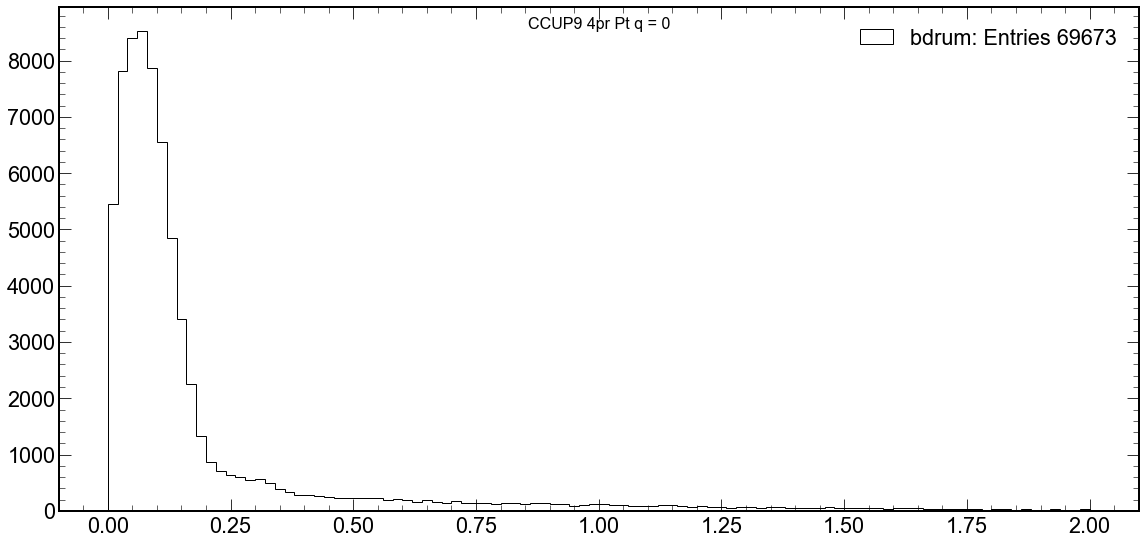

In [133]:
select = ((data['T_HasPointOnITSLayer0']) + (data['T_HasPointOnITSLayer1'])) * data['T_ITSRefit']  * (np.abs(data['T_NumberOfSigmaITSPion']) < 3) #* data['T_TPCRefit']  * (data['T_TPCNCls'] > 50) * (data['T_ITSNCls'] >3)
# get only events with 4 tracks
# GoodEvents = np.argwhere(select.counts==4)
# GoodEvents = GoodEvents[(np.argwhere(select[GoodEvents].sum().flatten()==4)).flatten()]

GoodEvents = np.argwhere(select.sum()==4)

# get events that have total zero charge from 4 tracks 
GoodEvents = GoodEvents[np.argwhere(data['T_Q'][GoodEvents.flatten()].sum()==0).flatten()].flatten()
GoodEvents = GoodEvents[np.argwhere(data['IsCUP9'][GoodEvents.flatten()]==True).flatten()].flatten()

pxg = data['T_Px'][GoodEvents]
pyg = data['T_Py'][GoodEvents]
pzg = data['T_Pz'][GoodEvents]

pt = np.sqrt(pxg.sum()**2  + pyg.sum()**2)
counts, bins = np.histogram(pt,bins=100, range=(0,2))
fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle('CCUP9 4pr Pt q = 0', fontsize=16)
plt.style.use(hep.style.ROOT)
ax.hist(pt, bins=bins, histtype='step', color='black', label=f'bdrum: Entries {np.sum(counts)}')
# countspvn, binspvn = np.histogram(pvnPt.flatten(),bins=100, range=(0,2))
# ax.hist(pvnPt.flatten(), bins=binspvn, histtype='step', color='red', label=f'PVN: Entries {np.sum(countspvn)}')
ax.legend()
print (counts.sum())

# 51 fitted events without limitations on tracks 

## Mass

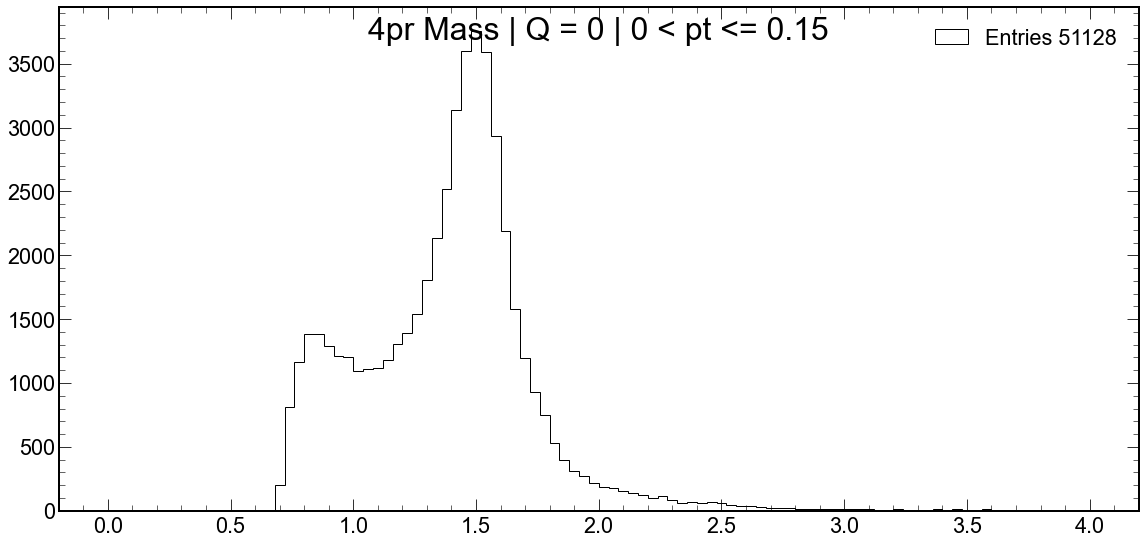

In [134]:
def GetMass(TrackNum=4, Trigger='IsCUP9', ChargeEqualCondition=True, charge=0, ptMin=0, ptMax=0.15, Draw=True):

    GoodEvents = np.argwhere(select.counts==TrackNum)
    GoodEvents = GoodEvents[(np.argwhere(select[GoodEvents].sum().flatten()==TrackNum)).flatten()]

    # get events that have total charge from 4 tracks 
    GoodEvents = GoodEvents[np.argwhere(data[Trigger][GoodEvents.flatten()]==True).flatten()].flatten()
    if ChargeEqualCondition:
        GoodEvents = GoodEvents[np.argwhere(data['T_Q'][GoodEvents.flatten()].sum()==charge).flatten()].flatten()
    else:
        GoodEvents = GoodEvents[np.argwhere(data['T_Q'][GoodEvents.flatten()].sum()!=charge).flatten()].flatten()
            
    pxg = data['T_Px'][GoodEvents]
    pyg = data['T_Py'][GoodEvents]
    pzg = data['T_Pz'][GoodEvents]
    massPion = np.full(pxg.shape[0], 0.140)
    pt = np.sqrt(pxg.sum()**2  + pyg.sum()**2)

    Energy0 = np.sqrt(massPion**2 + pxg[:,0]**2 + pyg[:,0]**2 + pzg[:,0]**2)
    Energy1 = np.sqrt(massPion**2 + pxg[:,1]**2 + pyg[:,1]**2 + pzg[:,1]**2)
    Energy2 = np.sqrt(massPion**2 + pxg[:,2]**2 + pyg[:,2]**2 + pzg[:,2]**2)
    Energy3 = np.sqrt(massPion**2 + pxg[:,3]**2 + pyg[:,3]**2 + pzg[:,3]**2)

    Energy = Energy0 + Energy1 + Energy2 + Energy3
    
    Mass = np.sqrt(Energy**2 - pxg.sum()**2 - pyg.sum()**2 - pzg.sum()**2)[(pt>ptMin)*(pt<=ptMax)]
    
    if Draw:
        fig = plt.figure(figsize=(15, 7))
        ax = fig.add_axes([0,0,1,1])
        if ChargeEqualCondition:
            fig.suptitle(f'4pr Mass | Q = 0 | {ptMin} < pt <= {ptMax}', fontsize=32)
        else:
            fig.suptitle(f'4pr Mass | Q != 0 | {ptMin} < pt <= {ptMax}', fontsize=32)
        plt.style.use(hep.style.ROOT)
        counts, bins = np.histogram(Mass, bins=100, range=(0,4))
        _ = ax.hist(Mass, bins=bins, color='black', histtype='step', label=f'Entries {np.sum(counts)}')
        ax.legend()
    else:
        return Mass
    
GetMass()

## Mass - pt - charge distirbution

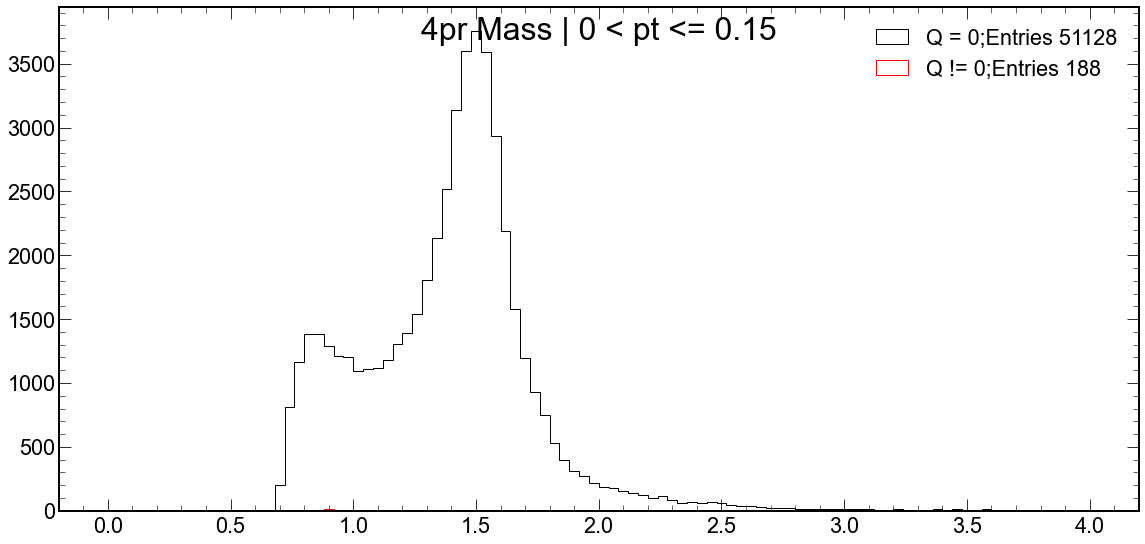

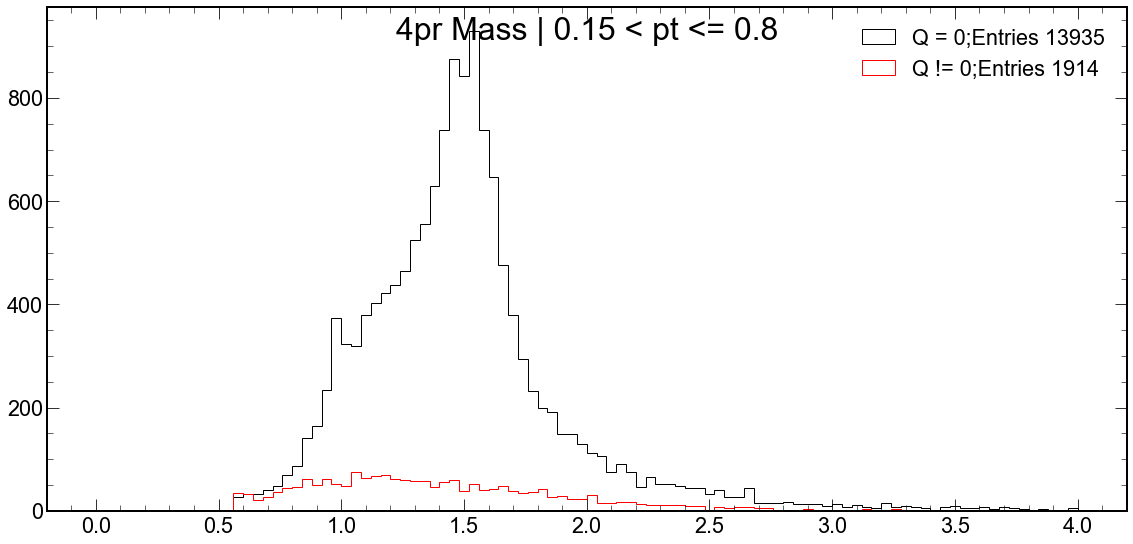

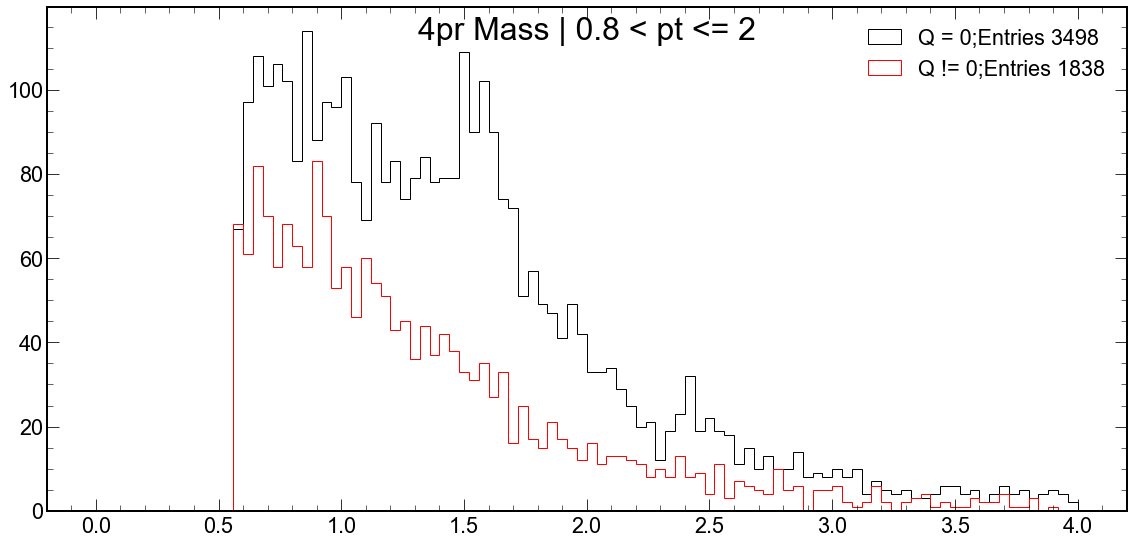

In [115]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'4pr Mass | {0} < pt <= {0.15}', fontsize=32)
plt.style.use(hep.style.ROOT)
counts, bins = np.histogram(GetMass(Draw=False), bins=100, range=(0,4))
_ = ax.hist(GetMass(Draw=False), bins=bins, color='black', histtype='step', label=f'Q = 0;Entries {np.sum(counts)}')
counts, bins = np.histogram(GetMass(ChargeEqualCondition=False,Draw=False), bins=100, range=(0,4))
_ = ax.hist(GetMass(ChargeEqualCondition=False,Draw=False), bins=bins, color='red', histtype='step', label=f'Q != 0;Entries {np.sum(counts)}')
ax.legend()

fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'4pr Mass | {0.15} < pt <= {0.8}', fontsize=32)
plt.style.use(hep.style.ROOT)
counts, bins = np.histogram(GetMass(Draw=False, ptMin=0.15, ptMax=0.8), bins=100, range=(0,4))
_ = ax.hist(GetMass(Draw=False,ptMin=0.15, ptMax=0.8), bins=bins, color='black', histtype='step', label=f'Q = 0;Entries {np.sum(counts)}')
counts, bins = np.histogram(GetMass(ChargeEqualCondition=False,Draw=False,ptMin=0.15, ptMax=0.8), bins=100, range=(0,4))
_ = ax.hist(GetMass(ChargeEqualCondition=False,Draw=False,ptMin=0.15, ptMax=0.8), bins=bins, color='red', histtype='step', label=f'Q != 0;Entries {np.sum(counts)}')
ax.legend()

fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'4pr Mass | {0.8} < pt <= {2}', fontsize=32)
plt.style.use(hep.style.ROOT)
counts, bins = np.histogram(GetMass(Draw=False, ptMin=0.8, ptMax=2), bins=100, range=(0,4))
_ = ax.hist(GetMass(Draw=False,ptMin=0.8, ptMax=2), bins=bins, color='black', histtype='step', label=f'Q = 0;Entries {np.sum(counts)}')
counts, bins = np.histogram(GetMass(ChargeEqualCondition=False,Draw=False,ptMin=0.8, ptMax=2), bins=100, range=(0,4))
_ = ax.hist(GetMass(ChargeEqualCondition=False,Draw=False,ptMin=0.8, ptMax=2), bins=bins, color='red', histtype='step', label=f'Q != 0;Entries {np.sum(counts)}')
ax.legend()



## $\rho -> \pi^+\pi^-2\pi^0$  vs $\rho -> \pi^+\pi^-\pi^+\pi^-$


In [60]:
GoodEvents = np.argwhere(select.counts==4)
GoodEvents
# get events that have total charge from 4 tracks 
# GoodEvents = GoodEvents[np.argwhere(data['IsCUP9'][GoodEvents.flatten()]==True).flatten()].flatten()
# GoodEvents = GoodEvents[np.argwhere(data['T_Q'][GoodEvents.flatten()].sum()==0).flatten()].flatten()
#(data['T_Q'][GoodEvents.flatten()]==1).sum()
data['T_Q'][1]         
# pxg = data['T_Px'][GoodEvents][select[GoodEvents]]
# pyg = data['T_Py'][GoodEvents][select[GoodEvents]]
# pzg = data['T_Pz'][GoodEvents][select[GoodEvents]]
# massPion = np.full(pxg.shape[0], 0.140)
# pt = np.sqrt(pxg.sum()**2  + pyg.sum()**2)

# Energy0 = np.sqrt(massPion**2 + pxg[:,0]**2 + pyg[:,0]**2 + pzg[:,0]**2)
# Energy1 = np.sqrt(massPion**2 + pxg[:,1]**2 + pyg[:,1]**2 + pzg[:,1]**2)
# Energy2 = np.sqrt(massPion**2 + pxg[:,2]**2 + pyg[:,2]**2 + pzg[:,2]**2)
# Energy3 = np.sqrt(massPion**2 + pxg[:,3]**2 + pyg[:,3]**2 + pzg[:,3]**2)
# Energy = Energy0 + Energy1 + Energy2 + Energy3
    
# Mass = np.sqrt(Energy**2 - pxg.sum()**2 - pyg.sum()**2 - pzg.sum()**2)[(pt>ptMin)*(pt<=ptMax)]
    

# fig = plt.figure(figsize=(15, 7))
# ax = fig.add_axes([0,0,1,1])
# fig.suptitle(f'4pr Mass | Q != 0 | {ptMin} < pt <= {ptMax}', fontsize=32)
# plt.style.use(hep.style.ROOT)
# counts, bins = np.histogram(Mass, bins=100, range=(0,4))
# _ = ax.hist(Mass, bins=bins, color='black', histtype='step', label=f'Entries {np.sum(counts)}')
# ax.legend()

array([-1,  1, -1,  1], dtype=int16)

## Energy losses

* all tracks

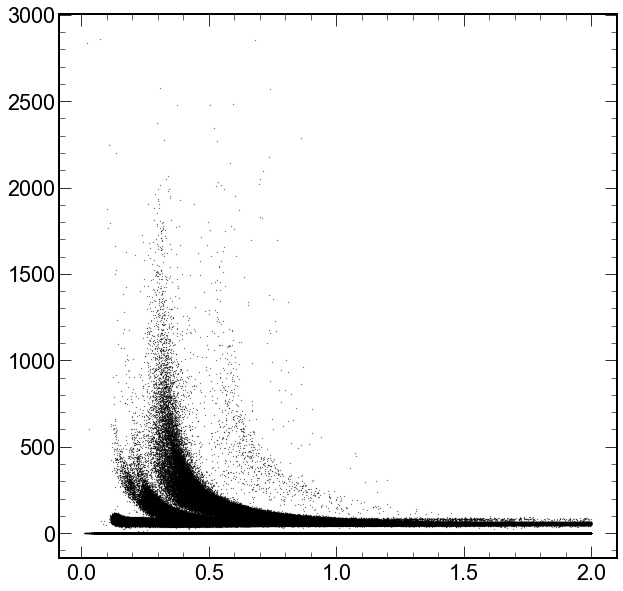

In [8]:
from scipy.stats import gaussian_kde

pt = np.sqrt(data['T_Px']**2 + data['T_Py']**2)#[(np.abs(data['T_NumberOfSigmaTPCPion']) < 3)]
dedx = data['TPCsignal'][(pt<2)].flatten()#[(np.abs(data['T_NumberOfSigmaTPCPion']) < 3)]
pt = pt[pt<2].flatten()
# z = gaussian_kde(pt)(dedx)

plt.style.use(hep.style.ROOT)
plt.scatter(pt.flatten(), dedx.flatten(),s=0.05, color='black')

* only selected events

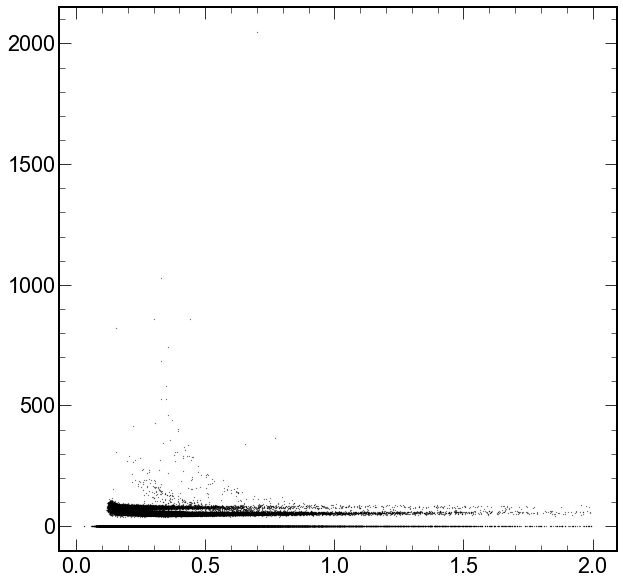

In [136]:
from scipy.stats import gaussian_kde

ptTracks = np.sqrt(pxg**2  + pyg**2).flatten()
dedx = data['TPCsignal'][GoodEvents].flatten()[ptTracks<2]
ptTracks = ptTracks[ptTracks<2]
# z = gaussian_kde(pt)(dedx)
plt.style.use(hep.style.ROOT)
plt.scatter(ptTracks.flatten(), dedx.flatten(),s=0.05, color = 'black')